# Introduction

The data comes from the past Kaggle challenge "Challenges in Representation Learning: Facial Expression Recognition Challenge":

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. Each image corresponds to a facial expression in one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains approximately 36K images.

The original data consisted in arrays with a greyscale value for each pixel. We converted this data into raw images and splitted them in multiple folders: 

images/<br>
&nbsp;&nbsp;&nbsp;&nbsp;train/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;angry/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;disgust/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fear/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;happy/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;neutral/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;sad/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;surprise/<br>
&nbsp;&nbsp;&nbsp;&nbsp;validation/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;angry/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;disgust/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fear/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;happy/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;neutral/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;sad/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;surprise/<br>

80% of our images are contained inside the train folder, and the last 20% are inside the validation folder.

# Quick data visualization

First let's see how our images look like:

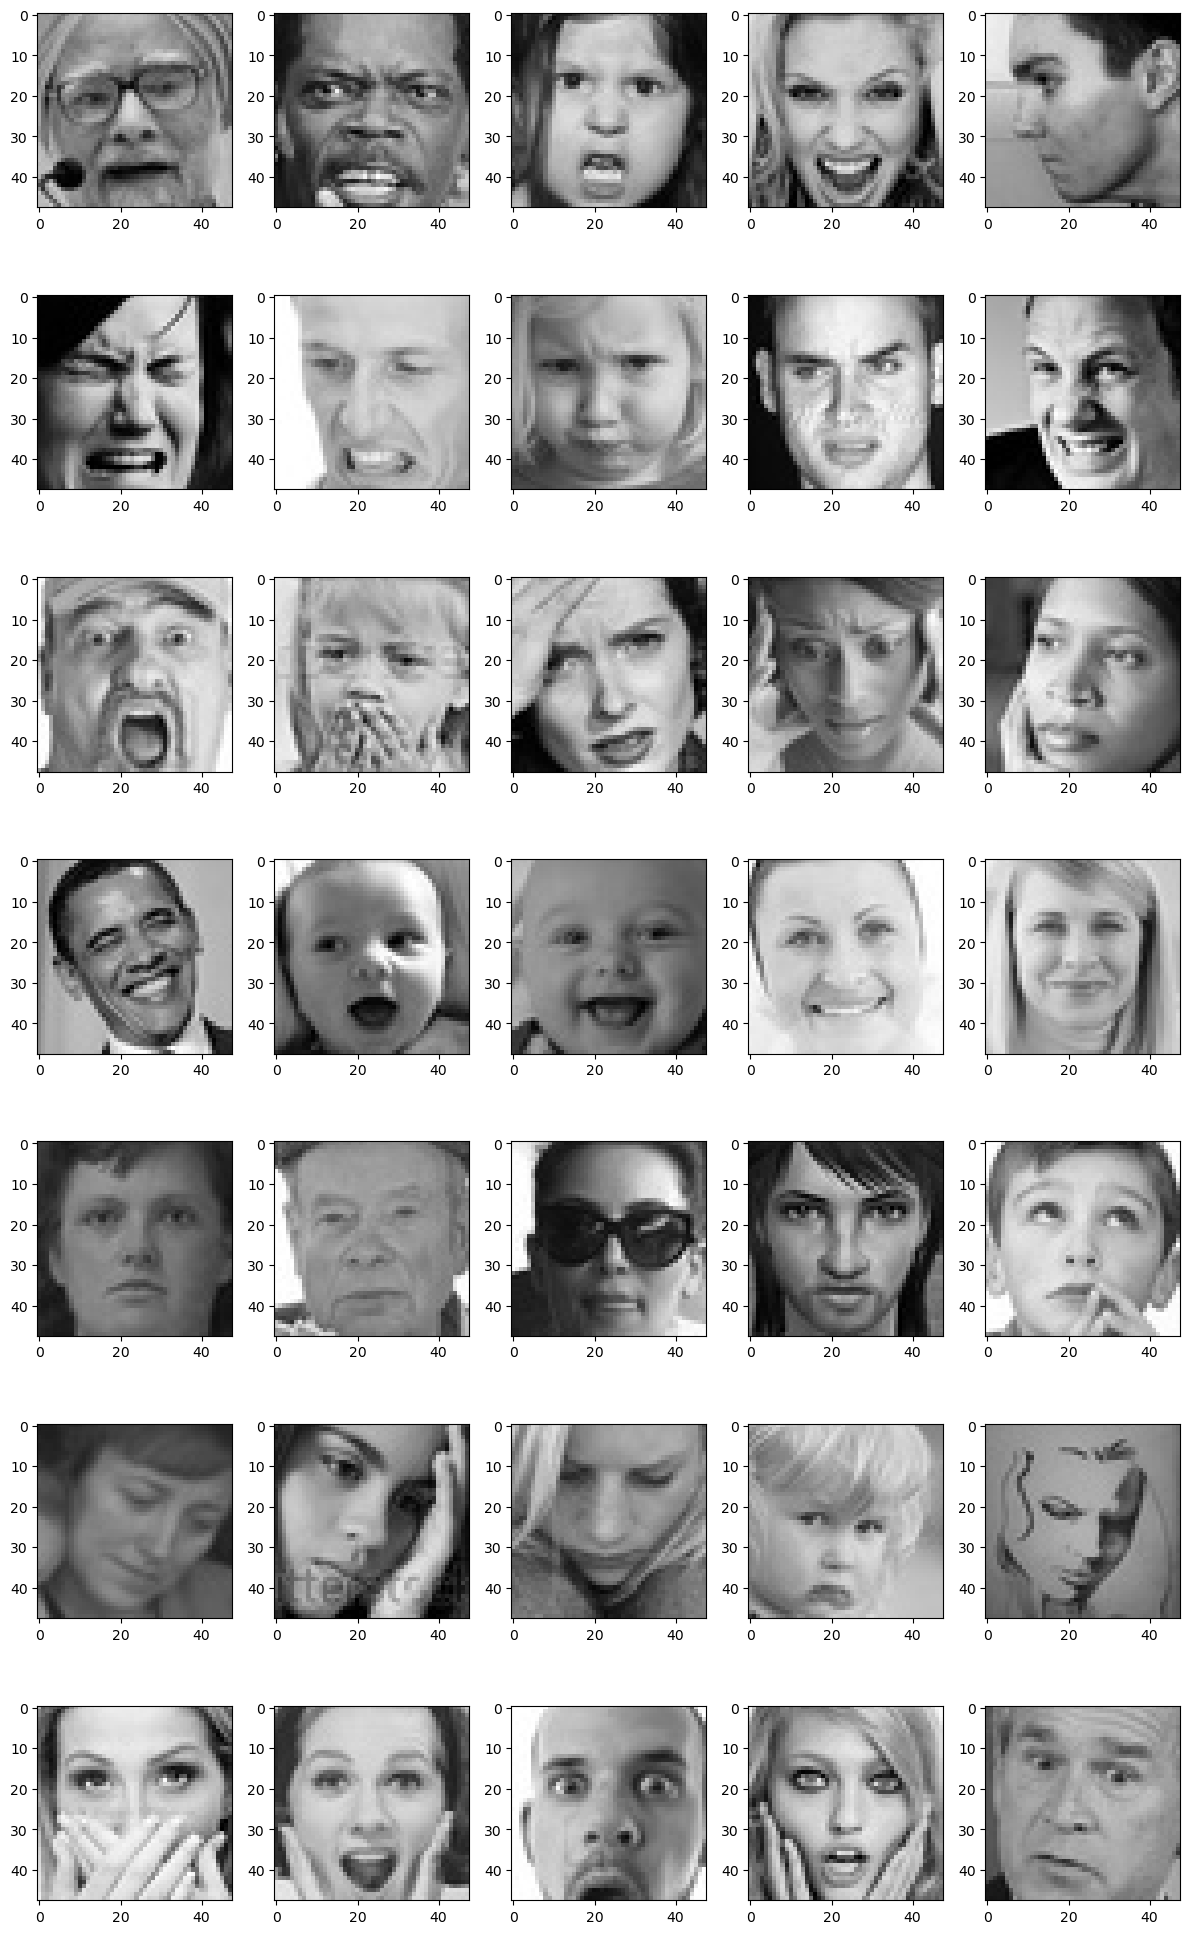

In [1]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "C:/Users/rasik/OneDrive/Documents/Emotion_recognition/Emotion-Recognition-based-on-CNN/input/images/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [2]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


# Setup the data generators

In [69]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [70]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [71]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
225/225 [==============================] - 36s 161ms/step - loss: 2.0174 - acc: 0.2333 - val_loss: 1.7391 - val_acc: 0.2966

Epoch 00001: val_acc improved from -inf to 0.29659, saving model to model_weights.h5
Epoch 2/50
225/225 [==============================] - 31s 138ms/step - loss: 1.8401 - acc: 0.2873 - val_loss: 1.7091 - val_acc: 0.3311

Epoch 00002: val_acc improved from 0.29659 to 0.33108, saving model to model_weights.h5
Epoch 3/50
225/225 [==============================] - 31s 138ms/step - loss: 1.7354 - acc: 0.3318 - val_loss: 1.6665 - val_acc: 0.3711

Epoch 00003: val_acc improved from 0.33108 to 0.37114, saving model to model_weights.h5
Epoch 4/50
225/225 [==============================] - 32s 142ms/step - loss: 1.6591 - acc: 0.3643 - val_loss: 1.6144 - val_acc: 0.3890

Epoch 00004: val_acc improved from 0.37114 to 0.38902, saving model to model_weights.h5
Epoch 5/50
225/225 [==============================] - 31s 138ms/step - loss: 1.5971 - acc: 0.3886 - val_los

225/225 [==============================] - 30s 133ms/step - loss: 0.8138 - acc: 0.6960 - val_loss: 1.0631 - val_acc: 0.6248

Epoch 00040: val_acc did not improve from 0.62799
Epoch 41/50
225/225 [==============================] - 30s 133ms/step - loss: 0.7960 - acc: 0.7033 - val_loss: 1.0399 - val_acc: 0.6329

Epoch 00041: val_acc improved from 0.62799 to 0.63289, saving model to model_weights.h5
Epoch 42/50
225/225 [==============================] - 30s 134ms/step - loss: 0.7713 - acc: 0.7117 - val_loss: 1.0080 - val_acc: 0.6473

Epoch 00042: val_acc improved from 0.63289 to 0.64730, saving model to model_weights.h5
Epoch 43/50
225/225 [==============================] - 30s 135ms/step - loss: 0.7598 - acc: 0.7161 - val_loss: 1.0069 - val_acc: 0.6467

Epoch 00043: val_acc did not improve from 0.64730
Epoch 44/50
225/225 [==============================] - 30s 134ms/step - loss: 0.7463 - acc: 0.7196 - val_loss: 1.0760 - val_acc: 0.6300

Epoch 00044: val_acc did not improve from 0.64730
E

In [72]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Analyze the results

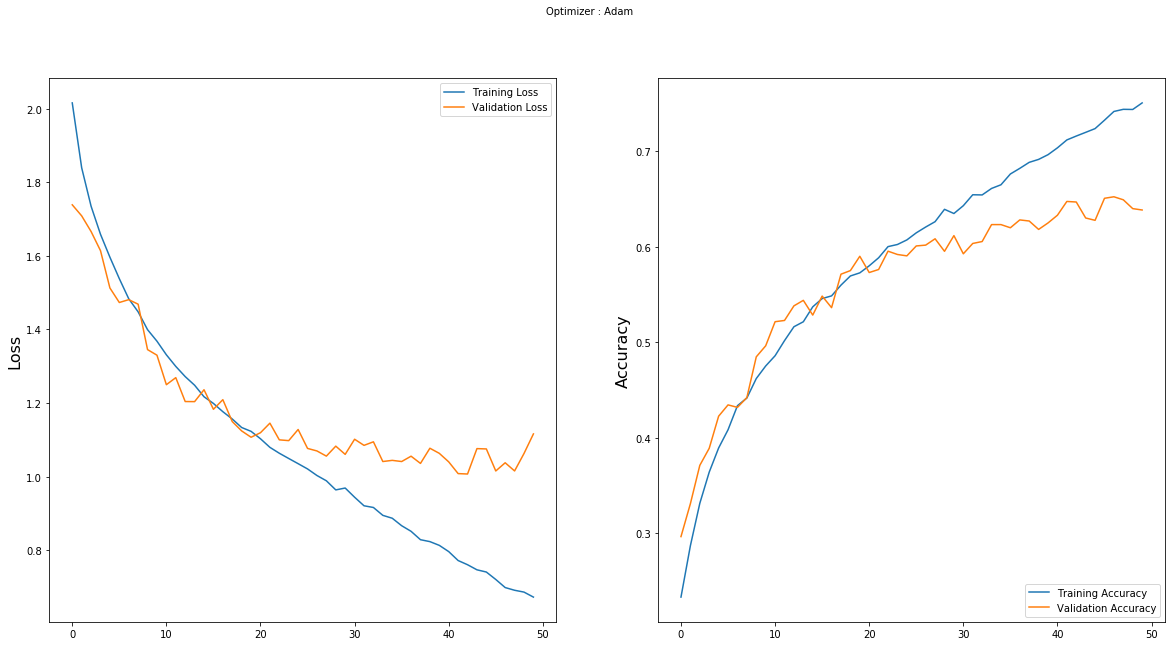

In [73]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

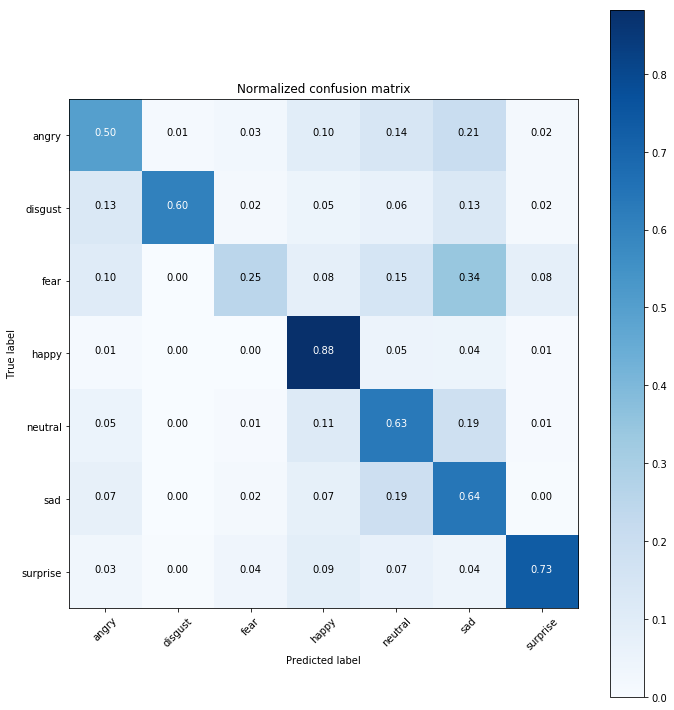

In [76]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.0.0


In [4]:
import cv2
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      